# Do some imports

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import datasets
#needed to create the Neural Network
import torch.nn as nn
import torch.nn.functional as F


#needed to preprocess the dataset
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

%matplotlib notebook
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# for the debugger

#general
pd.set_option('display.max_columns', 500)
import itertools

###### Run on the debugger mode

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [2]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [3]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define UNSW_NB15 class

In [4]:
class UNSW_NB15(torch.utils.data.Dataset):
    def __init__(self, file_path, sequence_length=25, transform=None):
        #TODO have a sequence_overlap=True flag? Does overlap matter?
        self.transform = transform
        self.sequence_length = sequence_length
        self.columns = ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']
        self.dtypes = dtypes = {"id":"int32",
                                "scrip": "string",
                                #"sport": "int32",
                                "dstip": "string",
                                #"dsport": "int32",
                                "proto": "string",
                                "state": "string",
                                "dur": "float64",
                                "sbytes": "int32",
                                "dbytes": "int32",
                                "sttl": "int32",
                                "dttl": "int32",
                                "sloss": "int32",
                                "dloss": "int32",
                                "service": "string",
                                "sload": "float64",
                                "dload": "float64",
                                "spkts": "int32",
                                "dpkts": "int32",
                                "swin": "int32",
                                "dwin": "int32",
                                "stcpb": "int32",
                                "dtcpb": "int32", 
                                #"smeansz": "int32",
                                #"dmeansz": "int32",
                                "trans_depth": "int32",
                                #"res_bdy_len": "int32",
                                "sjit": "float64",
                                "djit": "float64",
                                #"stime": "int64",
                                #"ltime": "int64",
                                #"sintpkt": "float64",
                                #"dintpkt": "float64",
                                "tcprtt": "float64",
                                "synack": "float64",
                                "ackdat": "float64",

                                #commenting these because they have mixed values and we aren't going to generate them anyway
                                #"is_sm_ips_ports": "int32",
                                #"ct_state_ttl": "int32",
                                #"ct_flw_httpd_mthd": "int32",
                                #"is_ftp_login": "int32",
                                #"is_ftp_cmd": "int32",
                                #"ct_ftp_cmd": "int32",
                                #"ct_srv_src": "int32",
                                ##"ct_dst_ltm": "int32", 
                                #"ct_src_ltm": "int32",
                                #"ct_src_dport_ltm": "int32",
                                #"ct_dst_sport_ltm": "int32",
                                #"ct_dst_src_ltm": "int32",
                                "attack_cat": "string",
                                "label": "int32"}
        self.categorical_column_values = {"proto":None, "state":None, "service":None, "attack_cat":None}

        self.dataframe = pd.read_csv(file_path, encoding="latin-1", names=self.columns,header=0, dtype=self.dtypes)
        #self.dataframe.sort_values(by=['stime']) #sort chronologically upon loading
        
        #load all the unique values of categorical features at the start
        #and make these accessible via a fast function call.
        for key in self.categorical_column_values:
            self.categorical_column_values[key] = self.dataframe[key].unique()

        #cache all the maximum values in numeric columns since we'll be using these for feature extraction
        self.maximums = {}
        for key in self.dtypes:
            if "int" in self.dtypes[key] or "float" in self.dtypes[key]:
                self.maximums[key] = max(self.dataframe[key])
        
        #------------------------------------------------
        self.dataframe = self.dataframe.drop(['id', 'attack_cat'],1)
               
       
        ##------Encoding string columns with value between 0 and n_classes-1----
        #le = preprocessing.LabelEncoder()
        #self.dataframe['attack_cat_encoded'] = le.fit_transform(self.dataframe['attack_cat'])
        #self.dataframe['proto_encoded'] = le.fit_transform(self.dataframe['proto'])
        #self.dataframe['service_encoded'] = le.fit_transform(self.dataframe['service'])
        #self.dataframe['state_encoded'] = le.fit_transform(self.dataframe['state'])
        #self.dataframe['state_encoded'], uniques = pd.factorize(self.dataframe.state)
        
        # ----------Normalising all numerical features--------------
        #cols_to_normalise = list(self.dataframe.columns.values)[:39]
        #self.dataframe[cols_to_normalise] = self.dataframe[cols_to_normalise].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        #self.dataframe[cols_to_normalise] = self.dataframe[cols_to_normalise].apply(lambda x: (x - x.min()) / (x.max() - x.min()))               
        
        #-----------Create pytorch tensor----------------
        #self.tensor = torch.Tensor(self.dataframe.values)
        
        
        
    def get_tensor(self):
        return self.tensor
    
    def get_dataframe(self):
        return self.dataframe
    
    def __len__(self):
        return len(self.dataframe.index) - self.sequence_length
    
    def __getitem__(self, index):
        #TODO need error checking for out of bounds?
        #TODO return x,y where y is the category of the example
        #since none corresponds to "normal" data
        
        list_of_dicts = []
        for i in range(index,index+self.sequence_length):
            list_of_dicts.append(self.dataframe.loc[i, :].to_dict())
        
        if self.transform is not None:
            return self.transform(self, list_of_dicts)
        
        return list_of_dicts
    
    #get a list of all the unique labels in the dataset
    def get_labels(self):
        return self.dataframe['label'].unique().tolist()
    
    #get a list of all the unique attack categories in the dataset
    def get_attack_categories(self):
        return self.dataframe['attack_cat'].unique().tolist()
    
    def get_list_of_categories(self, column_name):
        pass #TODO

    #limit the dataset to only examples in the specified category
    def use_only_category(self, category_name):
        if category_name not in self.get_attack_categories():
            return False
        
        new_dataframe = self.dataframe[self.dataframe['attack_cat'] == category_name]
        new_dataframe = new_dataframe.reset_index()
        self.dataframe = new_dataframe
        return True
    
    #limit the dataset to only examples with the specified label
    def use_only_label(self, label):
        if label not in self.get_labels():
            return False
        
        new_dataframe = self.dataframe[self.dataframe['label'] == label]
        new_dataframe = new_dataframe.reset_index()
        self.dataframe = new_dataframe
        return True

# Define the Neural Network class

In [5]:
# define NN architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, num_classes):
        super(Net,self).__init__()
        self.input_size = input_size
        # linear layer (input_size -> hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        # linear layer (hidden_size -> hidden_2)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        # linear layer (hidden_size_2 -> num_classes)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        #self.droput = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        #x is the input tensor
        out = self.fc1(x)
        #add hidden layer, with relu activation function
        out = self.relu(out)
        out = self.fc2(out)
        # add hidden layer, with relu activation function
        out = self.relu(out)
        # add dropout instead of relu or not..?
        #out = self.droput(out)
        out = self.fc3(out)
        return out


In [6]:
def train_test_split(training_df: pd.DataFrame, testing_df: pd.DataFrame):
    """Splits training and testing dataframe into x and y training and testing"""
    x_training_df = training_df.iloc[:, 0:-1].values
    y_training_df = training_df.iloc[:, -1].values # Last two (or 1 ?) columns are categories and labels
    
    x_testing_df = testing_df.iloc[:, 0:-1].values
    y_testing_df = testing_df.iloc[:, -1].values # Last two (or 1 ?) columns are categories and labels

    return x_training_df, y_training_df, x_testing_df, y_testing_df

In [7]:
def integer_encoding(training_df: pd.DataFrame, testing_df: pd.DataFrame):
    """Applies integer encoding to the proto, service and state columns"""
    training_df['train'] = 1
    testing_df['train'] = 0
    combined = pd.concat([training_df, testing_df])

    #do the integer encoding 
    le = preprocessing.LabelEncoder()

    #combined['attack_cat'] = le.fit_transform(combined['attack_cat'])
    combined['proto'] = le.fit_transform(combined['proto'])
    combined['service'] = le.fit_transform(combined['service'])
    combined['state'] = le.fit_transform(combined['state'])


    #split trainng and testing_df again
    training_df = combined [combined['train']== 1]
    testing_df = combined [combined['train']== 0]
    training_df = training_df.drop(['train'],1)
    testing_df = testing_df.drop(['train'],1)
   
    return training_df, testing_df

In [ ]:
training_df['train'] = 1
testing_df['train'] = 0
combined = pd.concat([training_df, testing_df])
combined = combined.reset_index()
string_columns= [["proto"],["service"],["state"]]

for column in string_columns:
        
    column_df = combined.loc[:, column]
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoder.fit(column_df)
    
    column_df_encoded = one_hot_encoder.transform(column_df)
    column_df_encoded = pd.DataFrame(data=column_df_encoded, columns=one_hot_encoder.categories_)
        return column_df_encoded, combined
        combined = pd.concat([combined, column_df_encoded], axis=1, sort=False)

    #delete proto,service and state columns
    #combined = combined.drop(list(itertools.chain.from_iterable(string_columns)),1)
combined = combined.drop(["proto", "service","state"],1)
    
    #split trainng and testing_df again
training_df = combined [combined['train']== 1]
testing_df = combined [combined['train']== 0]
training_df = training_df.drop(['train'],1)
testing_df = testing_df.drop(['train'],1)
       
training_df = training_df.reset_index()
testing_df = testing_df.reset_index()

In [18]:
def one_hot_encoding(training_df: pd.DataFrame, testing_df:pd.DataFrame):
    """Applies 1 hot encoding to the proto, service and state columns """
    
    training_df['train'] = 1
    testing_df['train'] = 0
    combined = pd.concat([training_df, testing_df])
    combined = combined.reset_index()
    string_columns= [["proto"],["service"],["state"]]

    for column in string_columns:
        
        column_df = combined.loc[:, column]
        one_hot_encoder = OneHotEncoder(sparse=False)
        one_hot_encoder.fit(column_df)
    
        column_df_encoded = one_hot_encoder.transform(column_df)
        column_df_encoded = pd.DataFrame(data=column_df_encoded, columns=one_hot_encoder.categories_)
        combined = pd.concat([combined, column_df_encoded], axis=1, sort=False)

    #delete proto,service and state columns
    #combined = combined.drop(list(itertools.chain.from_iterable(string_columns)),1)
    combined = combined.drop(["proto", "service","state"],1)
    
    #split trainng and testing_df again
    training_df = combined [combined['train']== 1]
    testing_df = combined [combined['train']== 0]
    training_df = training_df.drop(['train','index'],1)
    testing_df = testing_df.drop(['train','index'],1)
       
    training_df = training_df
    testing_df = testing_df

    return training_df, testing_df

## Initialize UNSW_NB15 class

In [24]:
#get the training dataframe
unsw_nb15_training = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
train = unsw_nb15_training.get_dataframe()

#get the testing dataframe
unsw_nb15_testing = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test = unsw_nb15_testing.get_dataframe()

#apply integer encoding
train, test = integer_encoding(train, test)

#apply 1 hot encoding
#train, test = one_hot_encoding(train, test)
#one_hot_encoding(training, testing)

# split into what it needed
x_train, y_train, x_test, y_test, = train_test_split(train, test)
#
#test.head()

In [29]:
test.shape

(82332, 43)

## Define some parameters first

In [30]:
input_size = 42 # 132 for 1hot encoding
hidden_size = 64      # 1st layer number of neurons
hidden_size_2 = 64    # 2nd layer number of neurons
num_classes = 2      # There are 9 different types of malicious packets + Normal

num_epochs = 20
batch_size = 32
learning_rate = 0.001

n_total_steps = len(x_train)

device = 'cpu'

## Initialize Neural Network class

In [31]:
model = Net(input_size, hidden_size, hidden_size_2, num_classes).to(device)
print(model)

Net(
  (fc1): Linear(in_features=42, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


## Define loss and optimizer 

In [32]:
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Train the model

In [33]:
losses = []
for epoch in tqdm(range(3)):
   
    for i in range(0, x_train.shape[0], batch_size):
        optimizer.zero_grad()

        x = torch.as_tensor(x_train[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_train[i:i+batch_size], dtype=torch.long).to(device)
        
        outputs = model(x)
        loss = criterion(outputs, y)
        losses.append(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()

## Check the loss

<ipython-input-34-d27d7360379f>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_axis,np.log(losses))


<IPython.core.display.Javascript object>


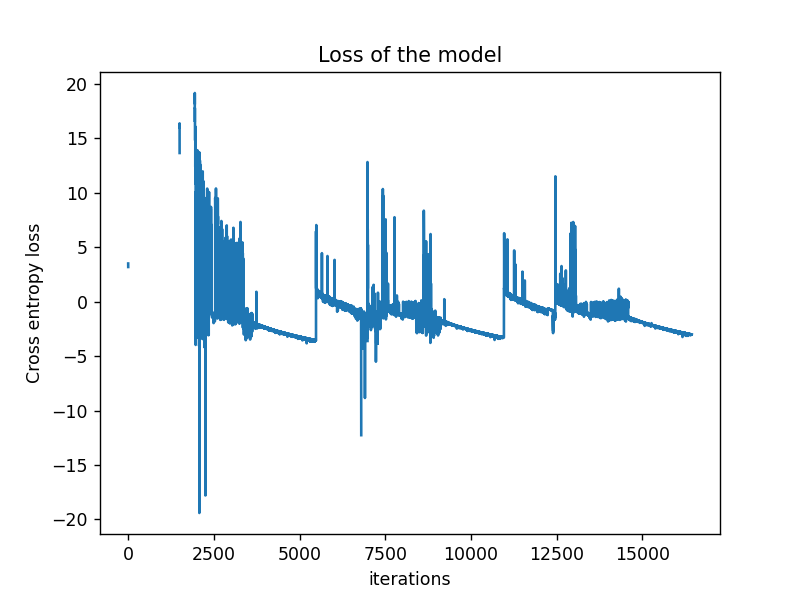

Text(0, 0.5, 'Cross entropy loss')

In [34]:
x_axis = [i for i in range(len(losses))]
plt.plot(x_axis,np.log(losses))
plt.title('Loss of the model')
plt.xlabel('iterations')
plt.ylabel('Cross entropy loss')

# Test the model

In [ ]:
pd.DataFrame(x_test).duplicated().sum()

In [37]:
x_test

array([[1.10e-05, 1.19e+02, 0.00e+00, ..., 1.00e+00, 2.00e+00, 0.00e+00],
       [8.00e-06, 1.19e+02, 0.00e+00, ..., 1.00e+00, 2.00e+00, 0.00e+00],
       [5.00e-06, 1.19e+02, 0.00e+00, ..., 1.00e+00, 3.00e+00, 0.00e+00],
       ...,
       [0.00e+00, 6.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00],
       [0.00e+00, 6.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00],
       [9.00e-06, 1.19e+02, 0.00e+00, ..., 1.00e+00, 1.00e+00, 0.00e+00]])

In [38]:
#%pixie_debugger
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0  
    for i in range(0, x_test.shape[0], batch_size):
        x = torch.as_tensor(x_test[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_test[i:i+batch_size], dtype=torch.long).to(device)
        
        outputs = model(x)
        #print(outputs)
        #print(len(outputs.data))
        if len(outputs.data) > 0:
            # max returns (value ,index)
            #print(torch.max(outputs.data, dim=1))
            _, predicted = torch.max(outputs.data, dim=1)
            
            n_samples += y.size(0)
            n_correct += (predicted == y).sum().item()
            #print("n_samples=", n_samples, "n_correct",n_correct )
        else:
            print("what???")
            print(x, outputs.data)
    acc = 100.0 * n_correct / (n_samples+1)
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 55.095769618500476 %


### Recreate this paper's results
    https://www.researchgate.net/publication/332100759_Intrusion_Detection_Using_Big_Data_and_Deep_Learning_Techniques